### About
This notebook attempts to study AlexNet. In this notebook I have tried to best understand the AlexNet architecture and summerise my understanding. Trained models are stored in the models/ directory in format - model_dataset_device_epochs_timestamp_accuracy.pth. I have done it this way to essentialy study how fast the model trains on different devices, how the accuracy improves with more epochs.

In [1]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()

        self.features = nn.Sequential(
            # conv layer 1
            # nn.Conv2d(in_channels=3, out_channels=64, kernel_size=11, stride=4, padding=2),
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # conv layer 2
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # conv layer 3
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # Conv Layer 4
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            # Conv Layer 5
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            # questions - why is there no maxpool2d for layers 3 and 4
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6,6))

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),

            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            
            # Final Output: Probability for each class (e.g., 10 classes for CIFAR-10)
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
            x = self.features(x)
            x = self.avgpool(x)
    
            x = torch.flatten(x, 1)
            
            x = self.classifier(x)
            
            return x

# CNN Architecture Concepts Summary

### 1. Convolutional Layer (`nn.Conv2d`)
**The "Feature Extractor"**
* **Role:** Transforms raw pixels into meaningful features (shapes, textures, edges).
* **Mechanism:** A 3D kernel (filter) slides over the input image.
    * **The Math:** It performs a **Dot Product** (element-wise multiplication + sum) on the pixels inside the window.
    * **Input vs. Output:** A generic 11x11 pixel area (121 numbers) is "crushed" into **1 single output pixel**.
* **Stride (The Jump):** * We use `stride=4`. The filter takes a snapshot, then jumps 4 pixels to the right.
    * **Result:** This significantly shrinks the image width/height (224 $\to$ 55) by "skipping" centering on every single pixel. We trade spatial resolution for abstraction.
* **Channels (Depth):** * **Input:** 3 Channels (Red, Green, Blue).
    * **Output:** 64 Channels.
    * **Why?** We are not creating 64 colors. We are creating **64 Feature Maps**. Filter 1 might look for vertical lines, Filter 2 for green blobs, Filter 3 for corners, etc.
* **How it knows what to find:** The filters start as random noise. Through **Backpropagation**, the model updates the filter weights to minimize error. Filters that detect useful patterns (like edges) survive; useless ones are changed.

### 2. ReLU (`nn.ReLU`)
**The "Non-Linearity" (The Hinge)**
* **Role:** Solves the "Linearity Trap." Without this, a neural network is just a stack of linear regressions (straight lines).
* **The Math:** $f(x) = max(0, x)$.
    * If $x$ is negative: Output 0.
    * If $x$ is positive: Output $x$.
* **Visual:** It creates a "hinge" or bent line. By stacking thousands of these hinges, the model can approximate any complex curve (ears, wheels, faces).
* **In-Place:** We use `inplace=True` to modify the data directly in memory, saving RAM.

### 3. Max Pooling (`nn.MaxPool2d`)
**The "Downsampler"**
* **Role:** Reduces the size of the feature maps to reduce computation and prevent overfitting.
* **Mechanism:** A window (e.g., 3x3) slides over the feature map.
* **The Action:** It looks at 9 numbers and keeps **only the largest one** (the strongest feature signal). The other 8 are discarded.
* **Result:** * Drastic reduction in spatial size (e.g., 55 $\to$ 27).
    * **Translation Invariance:** If a feature (like an eye) moves slightly to the left, the Max Pool window still captures it, making the model robust to small shifts.

# CNN Dimension Arithmetic Summary

### 1. The Golden Formulas
To calculate the output size of any layer, we use these two formulas.

**A. Convolution Output (with Padding)**
$$Output = \lfloor \frac{Input - Kernel + (2 \times Padding)}{Stride} + 1 \rfloor$$

**B. Pooling Output (usually Padding = 0)**
$$Output = \lfloor \frac{Input - Kernel}{Stride} + 1 \rfloor$$

---

### 2. Layer 1 Walkthrough (224 $\to$ 27)
**Step A: The Convolution** (Kernel 11, Stride 4, Padding 2)
* **Math:** $\lfloor \frac{224 - 11 + (2 \times 2)}{4} + 1 \rfloor$
* **Calculation:** $\lfloor \frac{217}{4} + 1 \rfloor = 54 + 1 = \mathbf{55}$
* *Result:* Feature Map is $55 \times 55$.

**Step B: The MaxPool** (Kernel 3, Stride 2)
* **Math:** $\lfloor \frac{55 - 3}{2} + 1 \rfloor$
* **Calculation:** $\frac{52}{2} + 1 = 26 + 1 = \mathbf{27}$
* *Result:* Final Layer 1 Output is $27 \times 27$.

---

### 3. Layer 2 Walkthrough (27 $\to$ 13)
**Step A: The Convolution** (Kernel 5, Stride 1, Padding 2)
* **Math:** $\lfloor \frac{27 - 5 + (2 \times 2)}{1} + 1 \rfloor$
* **Calculation:** $\frac{26}{1} + 1 = \mathbf{27}$
* *Observation:* The padding perfectly balances the kernel, so size stays constant.

**Step B: The MaxPool** (Kernel 3, Stride 2)
* **Math:** $\lfloor \frac{27 - 3}{2} + 1 \rfloor$
* **Calculation:** $\frac{24}{2} + 1 = \mathbf{13}$
* *Result:* Final Layer 2 Output is $13 \times 13$.

---

### 4. Layers 3 & 4 (Constant 13 $\to$ 13)
**The "Same Size" Trick**
These layers use a specific combination to prevent shrinking:
* **Kernel:** 3
* **Padding:** 1
* **Stride:** 1

**The Math:**
$$\frac{13 - 3 + (2 \times 1)}{1} + 1 = \frac{12}{1} + 1 = \mathbf{13}$$

**Why?** The designers wanted to increase the depth (channels) without losing any more spatial resolution (pixels) until the very end.

In [69]:
# Create the model
model = AlexNet(num_classes=10).to(device)

# Create a dummy input tensor: 
# Batch Size: 1 image
# Channels: 3 (RGB)
# Height/Width: 224 (Standard AlexNet size)
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Pass it through the model
output = model(dummy_input)

print(f"Input Shape: {dummy_input.shape}")
print(f"Output Shape: {output.shape}") 
# Expected Output Shape: [1, 10]

Input Shape: torch.Size([1, 3, 224, 224])
Output Shape: torch.Size([1, 10])


In [8]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

In [9]:
train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=0
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=0
)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print("Data loaded successfully!")

Files already downloaded and verified
Files already downloaded and verified
Data loaded successfully!


**Confirming the resize transform was successfull**

cat   ship  dog   truck
(3, 228, 906)


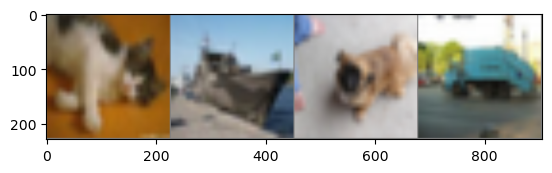

Image Size: torch.Size([3, 224, 224])


In [72]:
import matplotlib.pyplot as plt
import numpy as np

# Function to un-normalize and show an image
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize (bring back to 0-1 range)
    npimg = img.numpy()     # Convert from Tensor to Numpy array
    print(npimg.shape)
    # Transpose: PyTorch uses (Channels, Height, Width), Matplotlib wants (Height, Width, Channels)
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
imshow(torchvision.utils.make_grid(images[:4])) # Show top 4 images
print(f"Image Size: {images[0].shape}") # Should be 3x224x224

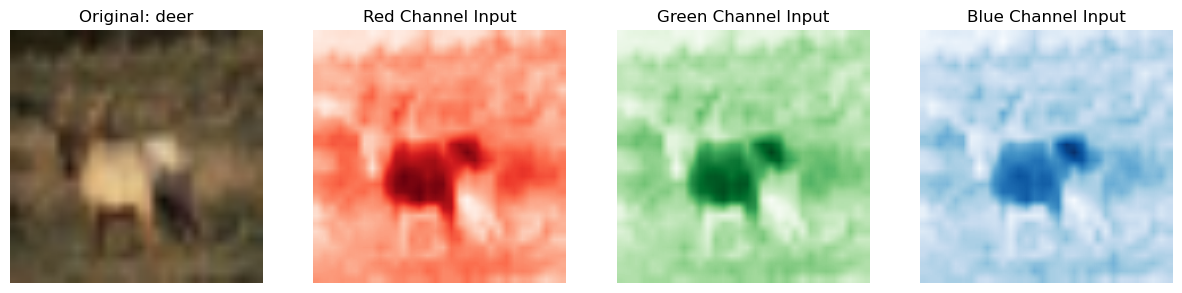

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Grab a single image from the dataset
# We take the 4th image (index 3) because it's usually a frog or animal with distinct colors
image, label = train_dataset[3] 

# 2. Un-normalize (Bring back to 0-1 range so we can see it properly)
image = image / 2 + 0.5 
np_img = image.numpy()

# 3. Create the Plot
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

# Plot 1: The Original Color Image
# Remember: We have to transpose (3, 224, 224) -> (224, 224, 3) for Matplotlib
axs[0].imshow(np.transpose(np_img, (1, 2, 0)))
axs[0].set_title(f'Original: {classes[label]}')
axs[0].axis('off')

# Plot 2: Red Channel (Index 0)
# We use 'Reds' colormap to make it intuitive, but computers see this as Grayscale.
axs[1].imshow(np_img[0], cmap='Reds') 
axs[1].set_title('Red Channel Input')
axs[1].axis('off')

# Plot 3: Green Channel (Index 1)
axs[2].imshow(np_img[1], cmap='Greens')
axs[2].set_title('Green Channel Input')
axs[2].axis('off')

# Plot 4: Blue Channel (Index 2)
axs[3].imshow(np_img[2], cmap='Blues')
axs[3].set_title('Blue Channel Input')
axs[3].axis('off')

plt.show()

# Channel Visualization & Feature Generation

### 1. RGB Channel Demonstration
**How Computers "See" Color**
* **The Concept:** A color image is not a single flat sheet; it is a stack of 3 separate matrices (Red, Green, Blue).
* **The Evidence:** When we visualized the separated channels of the frog/deer:
    * **White areas** = High intensity of that color (e.g., white in the Green channel = bright green grass).
    * **Black areas** = Absence of that color.
* **The Logic:** The model does not "see" a brown deer. It calculates mathematical correlations across these three layers (e.g., "High Red + High Green + Low Blue = Brown").

### 2. From 3 Input Channels to 64 Output Features
**Why 64? Are they colors?**
* **No, they are Feature Maps.** We are not creating 64 new colors; we are creating 64 maps that highlight **patterns**.
* **The Mechanism (3D Filters):**
    * Each of our 64 filters is actually a **3D block** (Depth = 3).
    * A single filter looks at the Red, Green, and Blue layers **simultaneously** and combines them into one output.
* **The "Bank" of Filters:**
    * **Filter 1** might evolve to detect **Vertical Edges** (Result: Map #1).
    * **Filter 2** might evolve to detect **Green Textures** (Result: Map #2).
    * **Filter 64** might evolve to detect **Contrast Gradients** (Result: Map #64).
* **The Evolution:** These features are not programmed. They start as random noise. Through **Backpropagation**, the model learns which 64 patterns are most useful for distinguishing the images (e.g., edges $\to$ curves $\to$ shapes) and updates the filters to find them.

In [74]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

print("Loss function and optimizer set up successfully!")

Loss function and optimizer set up successfully!


In [75]:
import matplotlib.pyplot as plt

num_of_epochs = 20
epoch_losses = [] # List to store the average loss per epoch

model.train()

print(f"Starting training for {num_of_epochs} epochs...")

for epoch in range(num_of_epochs):
    running_loss = 0.0      # For printing every 100 batches
    total_epoch_loss = 0.0  # For plotting the final graph
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Update stats
        current_loss = loss.item()
        running_loss += current_loss
        total_epoch_loss += current_loss

        # Print update every 100 batches
        if i % 100 == 99:
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

    # End of Epoch: Calculate true average and store it
    avg_loss = total_epoch_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    print(f"--- Epoch {epoch+1} finished. Average Loss: {avg_loss:.4f} ---")

print('Finished Training')

Starting training for 20 epochs...
[Epoch 1, Batch 100] loss: 2.303
[Epoch 1, Batch 200] loss: 2.303
[Epoch 1, Batch 300] loss: 2.303
[Epoch 1, Batch 400] loss: 2.302
[Epoch 1, Batch 500] loss: 2.302
[Epoch 1, Batch 600] loss: 2.302
[Epoch 1, Batch 700] loss: 2.302
--- Epoch 1 finished. Average Loss: 2.3024 ---
[Epoch 2, Batch 100] loss: 2.302
[Epoch 2, Batch 200] loss: 2.302
[Epoch 2, Batch 300] loss: 2.302
[Epoch 2, Batch 400] loss: 2.301
[Epoch 2, Batch 500] loss: 2.300
[Epoch 2, Batch 600] loss: 2.300
[Epoch 2, Batch 700] loss: 2.298
--- Epoch 2 finished. Average Loss: 2.2997 ---
[Epoch 3, Batch 100] loss: 2.284
[Epoch 3, Batch 200] loss: 2.268
[Epoch 3, Batch 300] loss: 2.185
[Epoch 3, Batch 400] loss: 2.136
[Epoch 3, Batch 500] loss: 2.116
[Epoch 3, Batch 600] loss: 2.088
[Epoch 3, Batch 700] loss: 2.074
--- Epoch 3 finished. Average Loss: 2.1527 ---
[Epoch 4, Batch 100] loss: 2.034
[Epoch 4, Batch 200] loss: 1.982
[Epoch 4, Batch 300] loss: 1.909
[Epoch 4, Batch 400] loss: 1.871

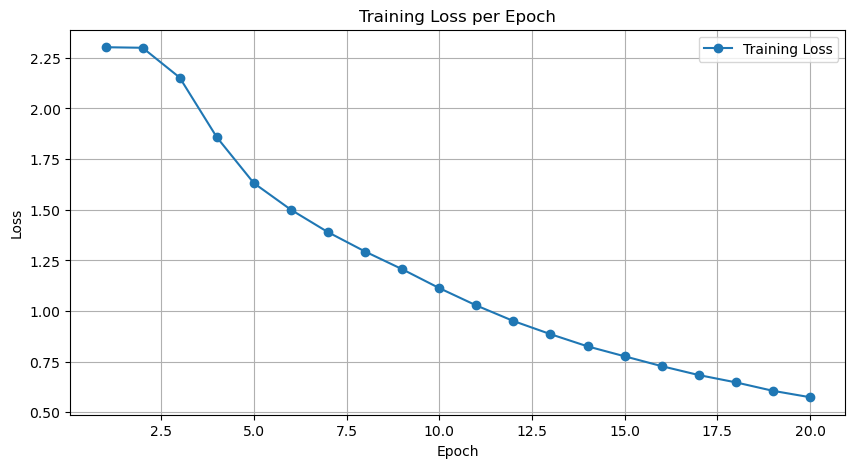

In [76]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_of_epochs+1), epoch_losses, marker='o', label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

# The Training Step "Dance"

### 1. `loss = criterion(outputs, labels)`
**The Measurement (No Gradients yet)**
* **Role:** Calculates the **Error Value** (a single number like `2.3`).
* **Analogy:** A Surveyor checking the map and saying, *"We are 500 meters too high."*
* **What it touches:** Nothing. It just reports how bad the guess was.

### 2. `loss.backward()`
**The Planning (Gradient Calculation)**
* **Role:** Calculates the **Gradients** (direction and magnitude of change needed) for every parameter.
* **Mechanism:** It goes backward through the network, calculating partial derivatives ($\frac{\partial Loss}{\partial Weight}$) and storing them in the `.grad` attribute of each weight.
* **Important:** It **does not** change the weights yet. It just writes the "To-Do List."
* **Analogy:** The Surveyor calculating, *"To go down, we need to move South-West."*

### 3. `optimizer.step()`
**The Action (Weight Update)**
* **Role:** Actually modifies the weights.
* **Mechanism:** It reads the `.grad` calculated by `backward()` and applies the update formula:
  $$NewWeight = OldWeight - (LearningRate \times Gradient)$$
* **Analogy:** The Hiker actually taking the step.

### 4. `optimizer.zero_grad()`
**The Reset**
* **Role:** Clears the old gradients from the previous step.
* **Why?** PyTorch accumulates gradients by default. If you don't zero them, the new step's "South-West" instruction will be added to the old step's "North-East" instruction, causing the model to run in circles.

In [ ]:
# loaded_model = AlexNet(num_classes=10).to(device)

# path = "./models/alexnet_cifar10_cuda_20_1768839346_78.94.pth"

# loaded_model.load_state_dict(torch.load(path, map_location=device))

# loaded_model.eval()

# print("Model loaded successfully!")

C:\Users\Gaurav Sidana\AppData\Local\Temp\ipykernel_25440\3464216105.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(path, map_lo

Model loaded successfully!


In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import numpy as np

# model = loaded_model

y_pred = []
y_true = []

model.eval()

correct = 0
total = 0

print("Staring model evaluation")

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)

        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)

        # for the confusion matrix
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
cf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10,000 test images: {accuracy:.2f} %')

Staring loaded_model evaluation
Accuracy of the network on the 10,000 test images: 78.94 %


In [26]:
np.sum(cf_matrix, axis=1)

array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])

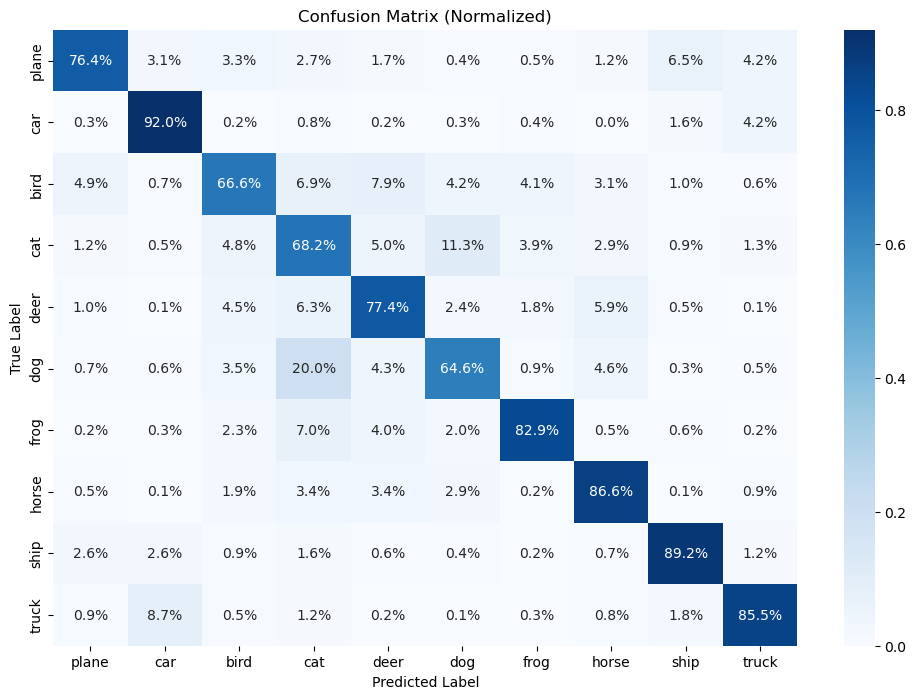

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index=[i for i in classes],
                     columns=[i for i in classes])


sns.heatmap(df_cm, annot=True, fmt='.1%', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Normalized)")
plt.show()

**Evaluation**
The currently trained model is struggling the most with classifying dogs, cats and birds as the accuracy for each is around 60-70%. It even predicts a cats image as frog later on. 
On the other hand can classify cars and trucks with higher accuracy. I imagined it would struggle with these the same way as cats and dogs because of similer shape, surprising.

In [78]:
import time

timestamp = int(time.time())
path = f'./models/alexnet_cifar10_{device}_{num_of_epochs}_{timestamp}_{accuracy:.2f}.pth'

torch.save(model.state_dict(), path)

print(f"Model saved to {path}")

Model saved to ./models/alexnet_cifar10_cuda_20_1768839346_78.94.pth


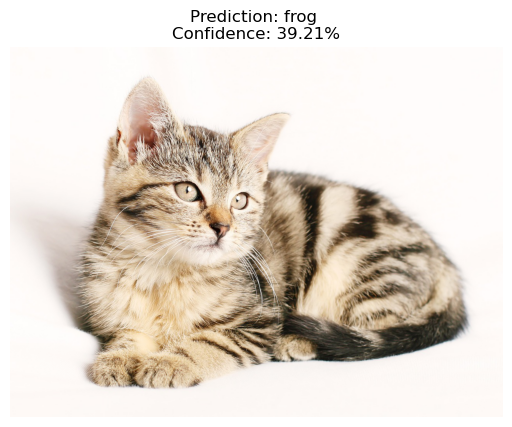

In [84]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 1. Define the standard CIFAR-10 classes (Just in case variable is lost)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

def predict_external_image(image_path):
    # A. Define the Transformation (Must match what we did during training)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),      # Resize to AlexNet standard
        transforms.ToTensor(),              # Convert to Tensor (0-1)
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize (-1 to 1)
    ])

    # B. Load Image
    try:
        # .convert('RGB') is crucial! It fixes errors if you download a PNG with transparency
        img = Image.open(image_path).convert('RGB')
    except:
        print(f"Error: Could not find image at {image_path}")
        return

    # C. Prepare the Image for the Model
    # The model expects a batch of images (Batch, Channel, Height, Width).
    # We only have 1 image, so we add a "fake batch" dimension at index 0.
    input_tensor = transform(img).unsqueeze(0).to(device)

    # D. Run Inference
    model.eval() # Turn off Dropout
    with torch.no_grad():
        output = model(input_tensor)
        
        # Calculate percentages using Softmax
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        
        # Get the top prediction
        confidence, predicted_idx = torch.max(probabilities, 0)
        
    # E. Display Result
    plt.imshow(img)
    plt.title(f"Prediction: {classes[predicted_idx.item()]} \nConfidence: {confidence.item()*100:.2f}%")
    plt.axis('off')
    plt.show()

# --- RUN IT ---
# Replace 'my_test_image.jpg' with the actual name of your file
predict_external_image('./images/test2.jpg')